# Logistična regresija

In [1]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

### Podatki

Najprej pripravimo podatke. Tokrat bomo zgradili učno množico z dvema atributoma (dve koloni v matriki $X$) in dvemi vrednostmi razredne spremeljivke y. Klasifikacijski problem, ki ga bomo obravnavali, je torej binaren.

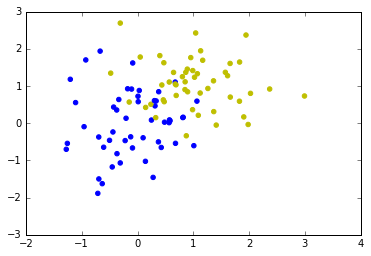

In [23]:
colors = np.array(['b', 'y'])
X, y = datasets.make_blobs(n_samples=100, centers=[[0, 0], [1, 1]], cluster_std=0.7)
X = np.column_stack((np.ones(len(X)), X))
plt.scatter(X[:, 1], X[:, 2], color=colors[y], s=20);

### Izris podatkov. Empirično testiranje modela

Ok, spodaj je najbolj kompliciran del naše kode, za katerega sem porabil tudi največ časa. To je lep izris razsevnega diagrama s podatki in s konturnim diagramom vrednosti verjetnosti razreda 1, kot ga napove logistična regresija s parametri theta. Funkcija f preslika vhodne podatke (atributni zapis primera) v nek drug prostor - potrebovali jo bomo pri polinomski logistični regresiji.

In [24]:
def h(theta, x):
    return 1. / (1 + np.exp(-x.dot(theta)))

def scatter(x, y, theta, f=None):
    """Plot the data and its linear regression model."""
    plt.scatter(X[:, 1], X[:, 2], color=colors[y], s=20);

    n = 200
    xr = np.linspace(x[:, 1].min(), x[:, 1].max(), n, endpoint=True)
    yr = np.linspace(x[:, 2].min(), x[:, 2].max(), n, endpoint=True)
    xg, yg = np.meshgrid(xr, yr, indexing="ij")
    z = np.zeros((len(xr), len(yr)))

    for i in range(len(xr)):
        for j in range(len(yr)):
            xi = np.array([1, xg[i, j], yg[i, j]], ndmin=2)
            z[i, j] = h(theta, f(xi) if f else xi)

    CS = plt.contour(xg, yg, z, [0.5, 0.4, 0.6, 0.1, 0.9], colors="k")
    # CS = plt.contour(z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlim(x[:, 1].min(), x[:, 1].max())
    plt.ylim(x[:, 2].min(), x[:, 2].max())

Zdaj pa vse skupaj: iz podatkov zgradimo model logistične regresije (ok, rabimo samo vrednosti parametrov modela, to je, thete) in napovedi modela izrišemo. Ne bi moglo biti bolj enostavno.

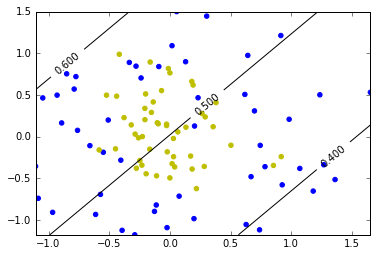

In [33]:
lr = LogisticRegression(C=10000, fit_intercept=False)
fitted = lr.fit(X, y)
scatter(X, y, fitted.coef_[0])

In [26]:
fitted.coef_

array([[-3.00951235,  3.36967368,  2.4206604 ]])

### Polinomska regresija

Kaj pa, če meja med primeri različnih razredov ni linearna, oziroma ni v obliki neke hiperravnine. V primeru, kjer imamo samo dva atributa, je ta meja kar premica, kot je razvidno iz slike zgoraj. Če bi primere opisali s tremi atributi, bi meja bila ravnina v tridimenzionalnem prostoru. Za večje število atributov pa hiperravnina. Ampak kako logistično regresijo prevarati tako, da nam ne vrača "ravnih" mej. Tako, kot pri linearni regresiji, to storimo z dodajanjem atributov, ki so višje potence (ali celo kombinacije) osnovnih atributov. Logistična regresija bo seveda še vedno vračala "linearni" model, a v nekem drugem prostoru. Njegova projekcija v prostor osnovnih atributov pa tam več ne bo linearna funkcija.

Pričnemo z oblikovanjem funkcije, ki v matriko podatkov doda kvadrate osnovnih atributov. Pravzaprav je to vse, kar potrebujemo.

In [27]:
def expand(X):
    return np.column_stack((X, X[:,1] * X[:,2], X[:,1]**2, X[:,2]**2))

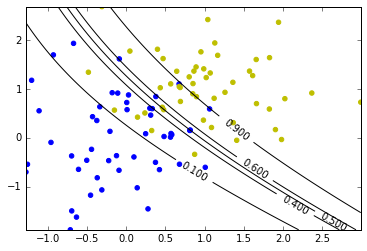

In [28]:
X2 = expand(X)
fitted = lr.fit(X2, y)
scatter(X2, y, fitted.coef_[0], f=expand)

Sedaj pa pravi test: zgradimo podatke, kjer ločnica med primeri različnih razredov ni več linearna funkcija.

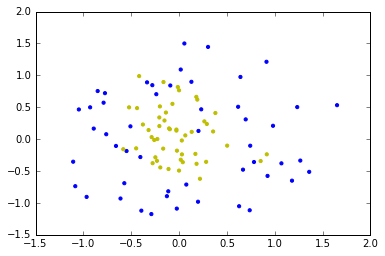

In [31]:
X, y  = datasets.make_circles(n_samples=100, factor=.3, noise=.3)
X = np.column_stack((np.ones(len(X)), X))
plt.scatter(X[:, 1], X[:, 2], color=colors[y], s=10);

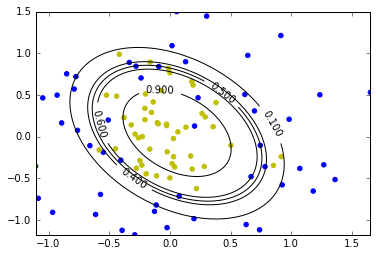

In [32]:
X2 = expand(X)
fitted = lr.fit(X2, y)
scatter(X2, y, fitted.coef_[0], f=expand)

Juhu! Dela. Prav presenetljivo za eno tako enostavno tehniko, kot je logistična regresija. Lahko se malo pozabaviš s spreminjanjem osnovnih podatkov. Zmanjaša ali povečaj njihovo število. Ali pa spreminjaj center in oddaljenost med področji s primeri enega razreda. Ali pa dodaj nove primere.

Spodaj spišemo še eno malo bolj splošno funkcijo za transformacijo, ki jo potrebujemo za logistično regresijo. V testiranju kmalu opazimo, da se logistična regresija preveč prilagodi primerom, če so ti opisani z mnogimi atributi. Opazimo tudi, da optimizacija rabi čedalje več časa za izračun. Kakšna bi bila rešitev tega problema? Bi znal zadevo pohitriti tako, da uporabiš kakšno boljšo optimizacijsko metodo? Poskusi!

In [34]:
def poly_expand(x, order=5):
    for o in range(2, order+1):
        for i in range(o+1):
            x = np.c_[x, (x[:, 1] ** i) * (x[:, 2] ** (o - i))]
    return x

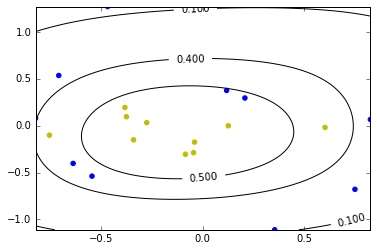

In [38]:
X, y  = datasets.make_circles(n_samples=20, factor=.3, noise=.3)
X = np.column_stack((np.ones(len(X)), X))
# poly = PolynomialFeatures(degree=2)
# X2 = poly.fit_transform(X)
X2 = poly_expand(X)
lr = LogisticRegression(penalty="l2", C=1)
fitted = lr.fit(X2, y)
scatter(X2, y, fitted.coef_[0], f=poly_expand)

In [37]:
fitted.coef_[0]

array([  2.70359286,   4.70275193,   3.55531237,   3.36018956,
        -0.92020292, -20.58018897,  -6.57096652,   4.83294468,
        -5.11682409, -12.69495166, -14.72674089,  -5.69222484,
        -4.89680185,   0.12640523,   5.62829959,   3.40109857,
        14.64346488,   2.90401692,   9.45633941,   5.21824903, -14.94105527])